In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()  


## 4. Pyramids for image blending In this task, we will stitch two images using pyramids.
Without pyramids, blending does not look natural because of discontinuities
between the pixel values. We will blend the images dog.jpeg and moon.jpeg.


* Load the two images dog.jpeg and moon.jpeg.

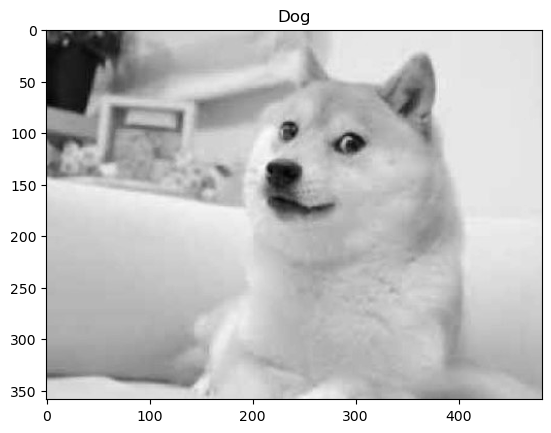

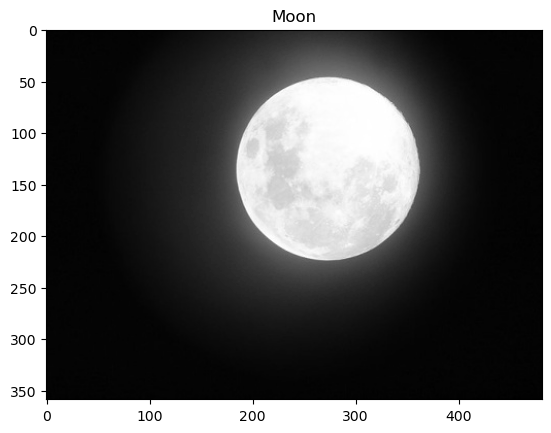

In [3]:
# set images pathes
dog_path = '../data/dog.jpeg'
moon_path = '../data/moon.jpeg'
# read imgs
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
moon = cv.imread(moon_path, cv.IMREAD_GRAYSCALE)

display_image('Dog', dog)
display_image('Moon', moon)

* Create the Gaussian Pyramids of the two images, and find their Laplacian
Pyramids LA and LB (remember that a Laplacian Pyramid is the difference
between two levels in the Gaussian Pyramid as explained in the lecture, i.e.
Li = Gi − expand(Gi+1)). Set the number of levels to 5.

In [4]:
def build_gaussian_pyramid_opencv(image, num_levels):
    pyramid = [image]
    for i in range(num_levels - 1):
        pyramid.append(cv.pyrDown(pyramid[i])) 
    return pyramid

In [5]:
def expand_opencv(image, shape):
    upscaled = cv.pyrUp(image)
    if(upscaled.shape[0] > shape[0] or upscaled.shape[1] > shape[1]):
        upscaled = upscaled[:shape[0], :shape[1]]
    return upscaled

In [6]:
def expand_my(image, shape):
    upscaled = np.repeat(image, 2, axis=0)
    upscaled = np.repeat(upscaled, 2, axis=1)
    if(upscaled.shape[0] > shape[0] or upscaled.shape[1] > shape[1]):
        upscaled = upscaled[:shape[0], :shape[1]]
    return upscaled

In [7]:
def build_laplacian_pyramid_opencv(gaussian_pyramid_image):
    pyramid = []
    for i in range(0, len(gaussian_pyramid_image) - 1):
        shape = gaussian_pyramid_image[i].shape
        expanded_img = expand_opencv(gaussian_pyramid_image[i+1], shape)
        laplacian_img = cv.subtract(gaussian_pyramid_image[i], expanded_img)
        pyramid.append(laplacian_img)
    pyramid.append(gaussian_pyramid_image[-1])
    return pyramid

In [8]:
gaussian_pyramid_dog = build_gaussian_pyramid_opencv(dog, 5)
gaussian_pyramid_moon = build_gaussian_pyramid_opencv(moon, 5)

In [9]:
laplacian_pyramid_dog = build_laplacian_pyramid_opencv(gaussian_pyramid_dog)
laplacian_pyramid_moon = build_laplacian_pyramid_opencv(gaussian_pyramid_moon)

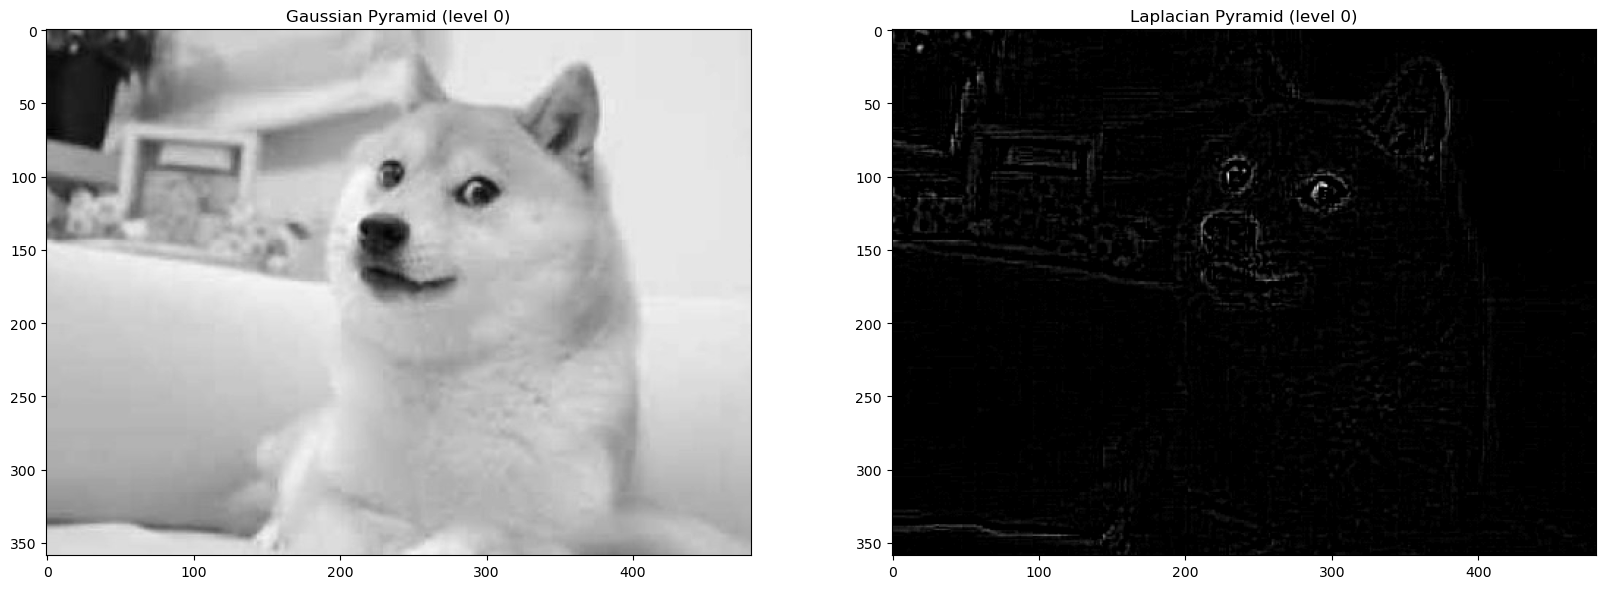

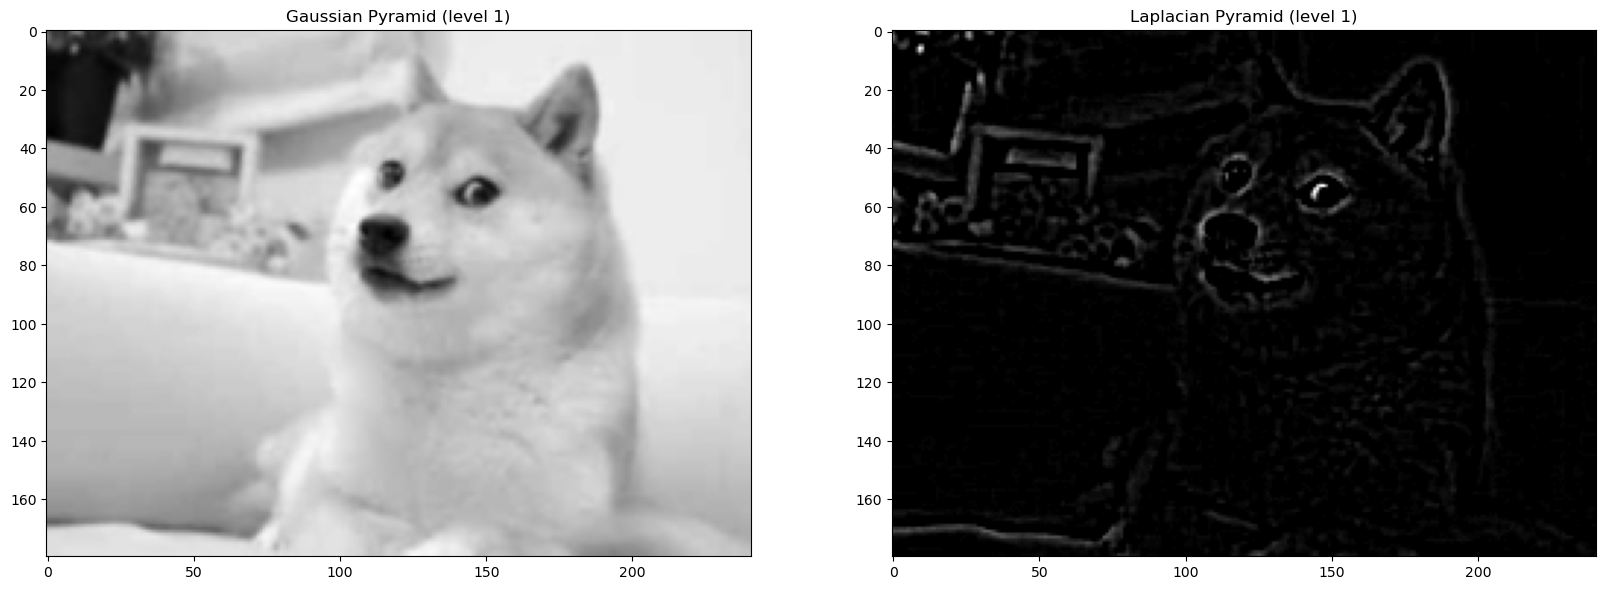

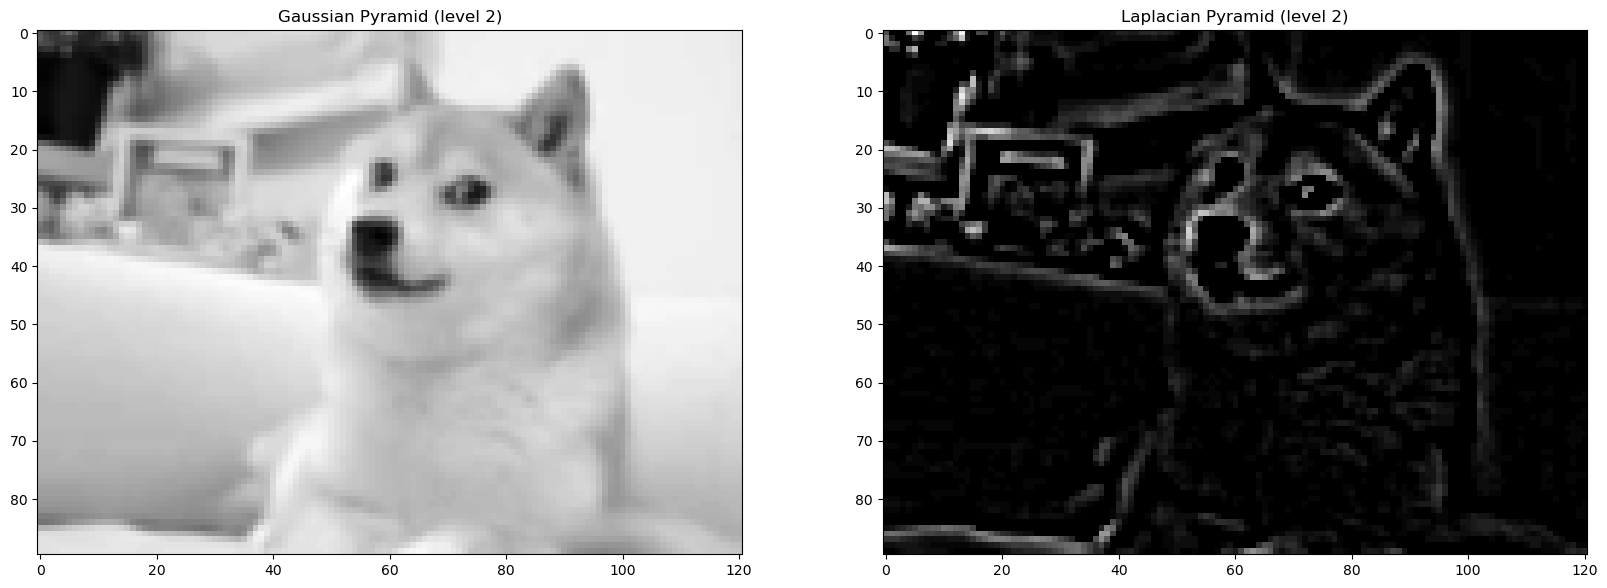

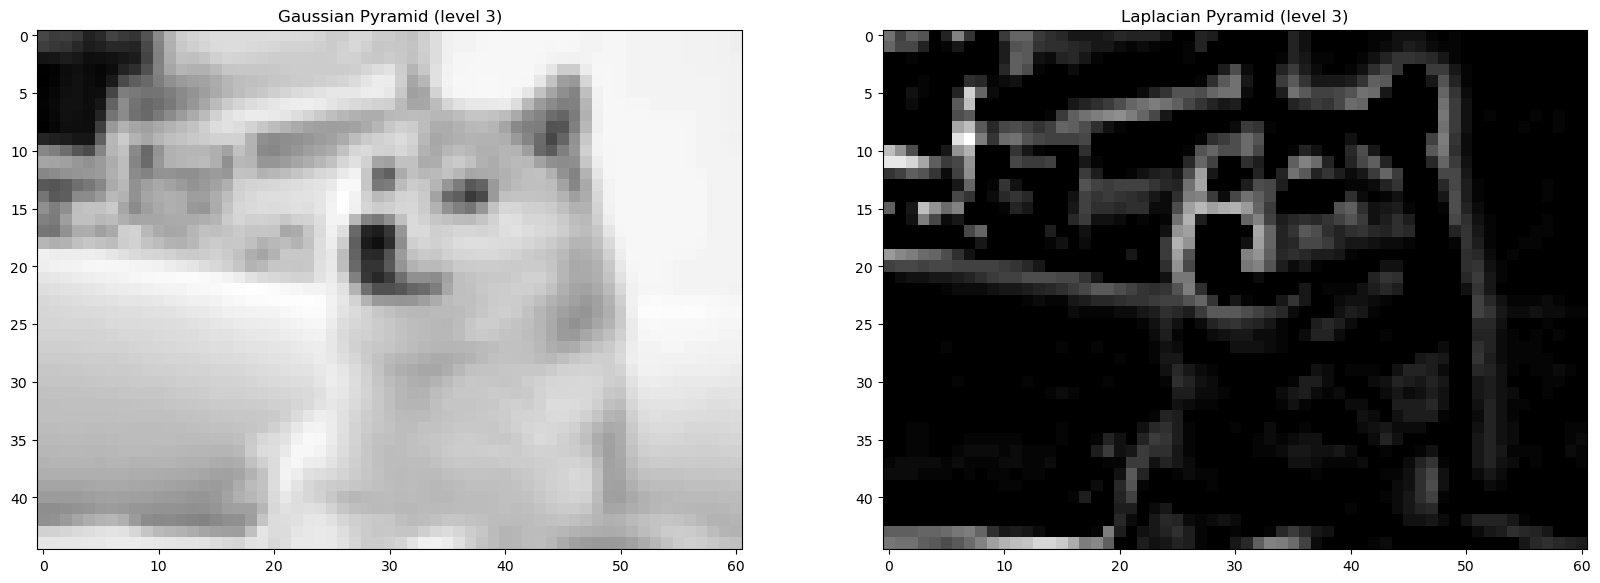

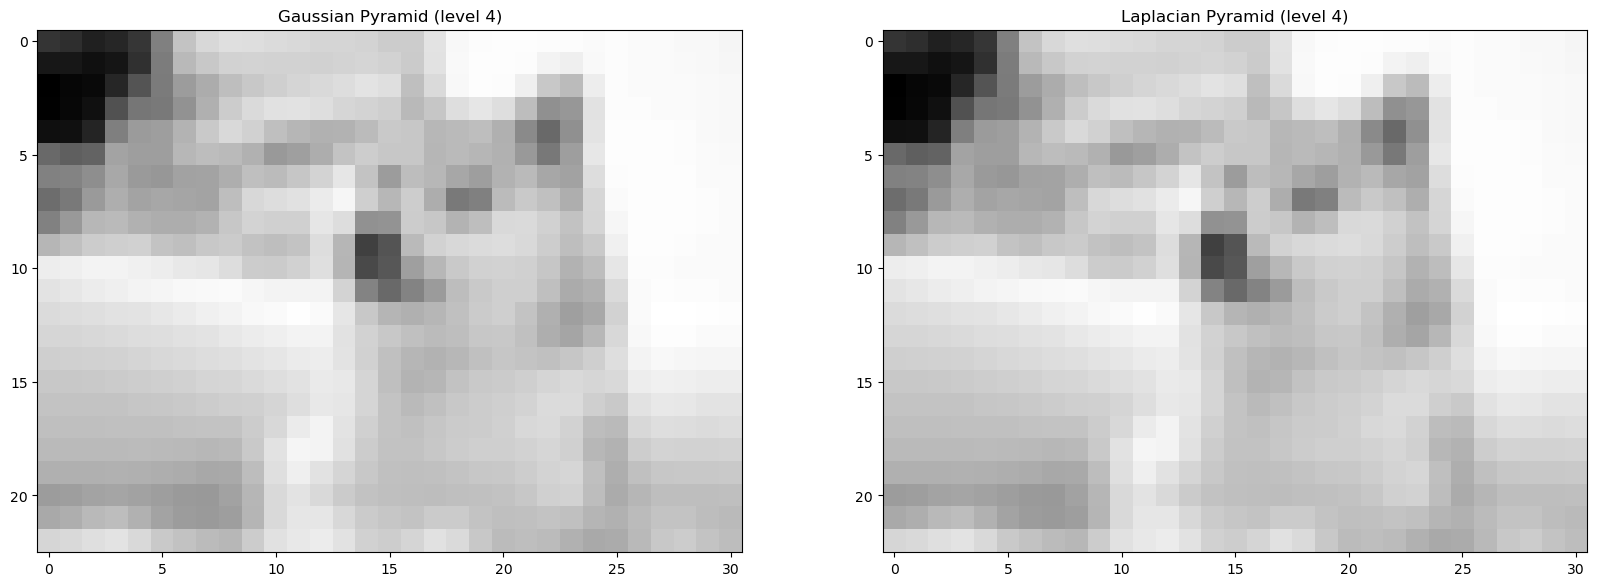

In [10]:
for i, el in enumerate(laplacian_pyramid_dog):
    display_image(f'Gaussian Pyramid (level {i})', gaussian_pyramid_dog[i], f'Laplacian Pyramid (level {i})', el)

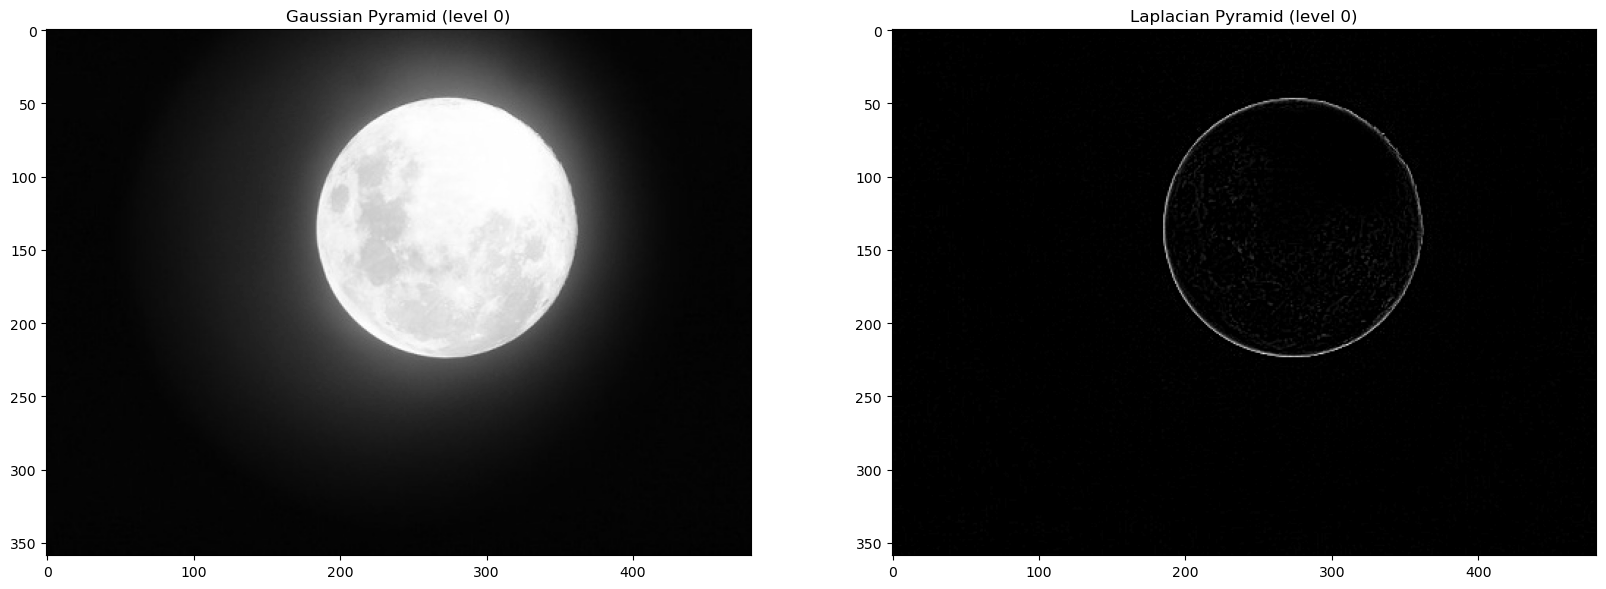

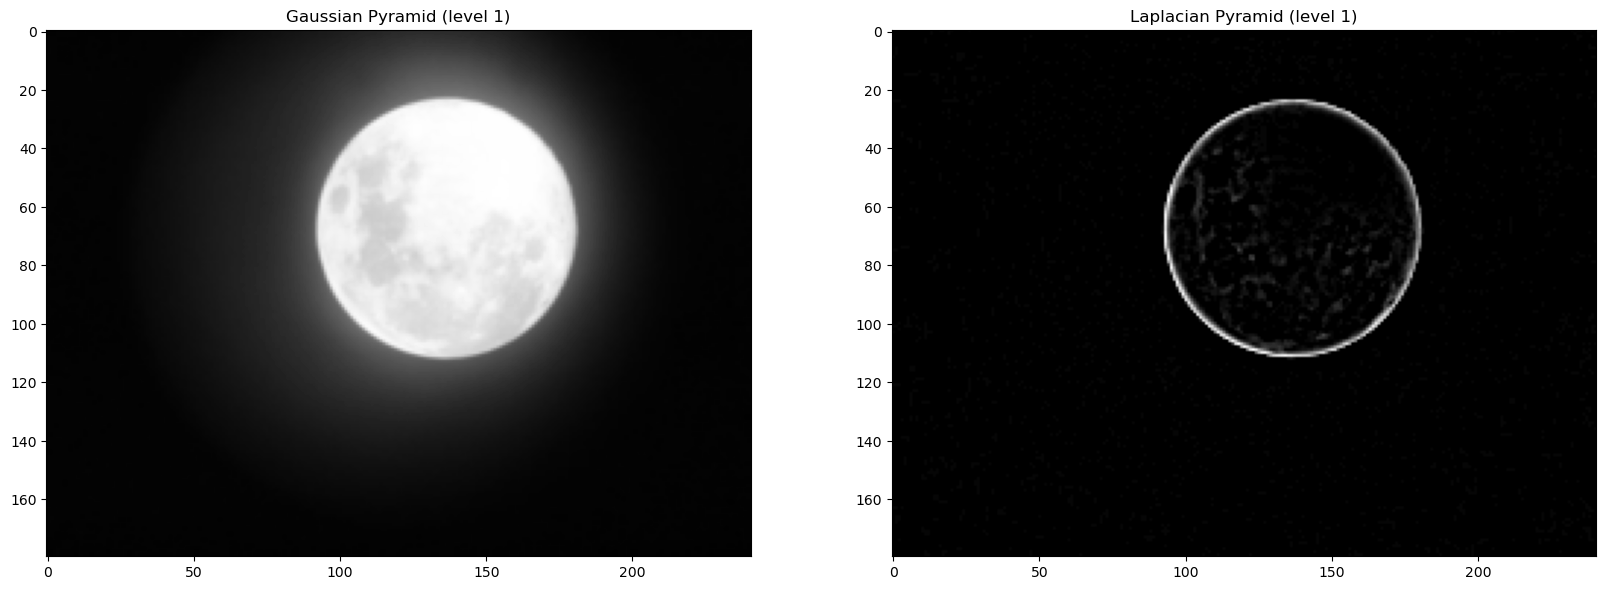

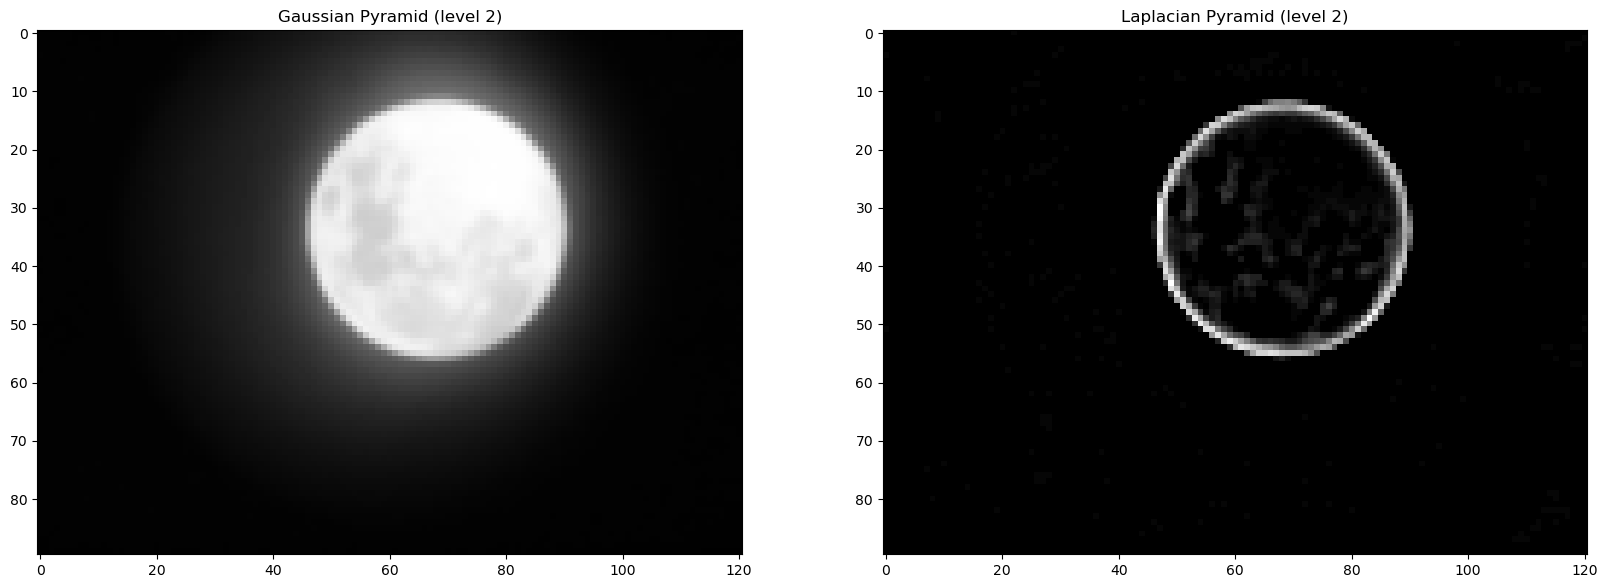

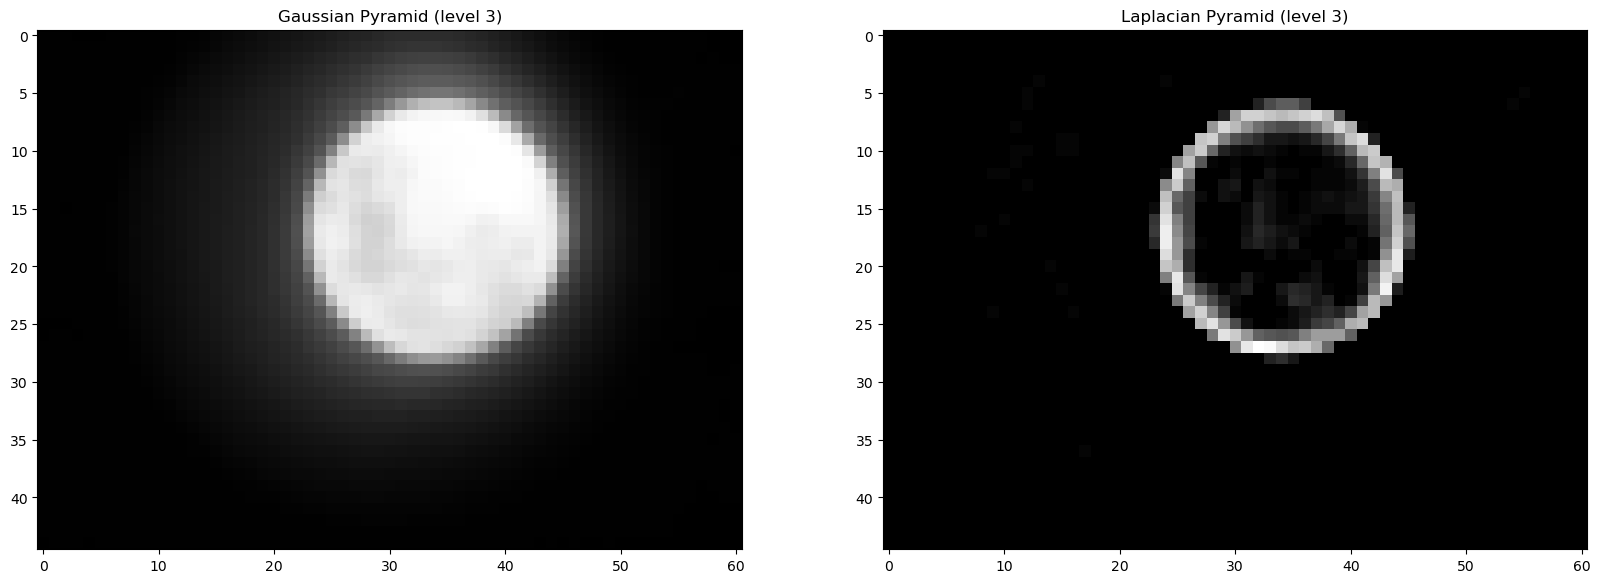

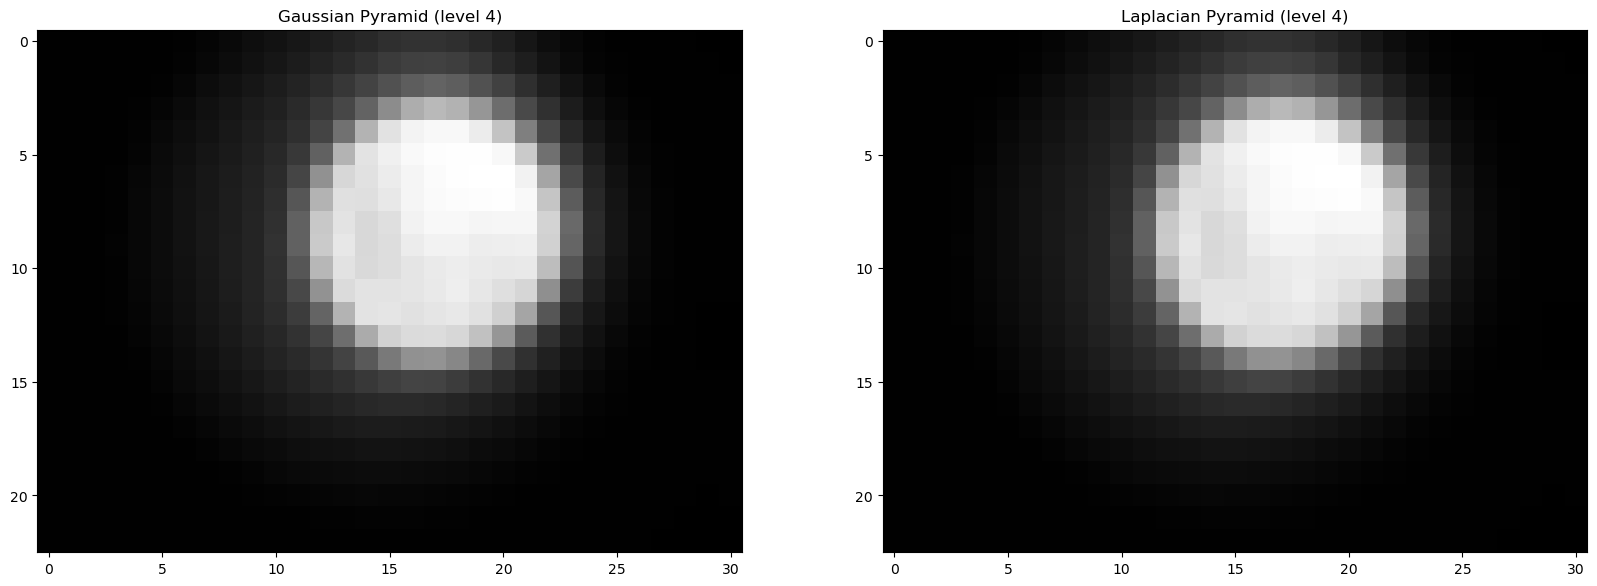

In [11]:
for i, el in enumerate(laplacian_pyramid_moon):
    display_image(f'Gaussian Pyramid (level {i})', gaussian_pyramid_moon[i], f'Laplacian Pyramid (level {i})', el)

* Blend the image dog.jpeg with the image moon.jpeg: create a Gaussian pyramid
GR for the region of interest in the given mask mask.jpeg (first transform
the mask to grayscale).

In [12]:
# set mask path
mask_path = '../data/mask.jpeg'
# read imgs
mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

# Build a Gaussian pyramid GR from selected region R
gaussian_pyramid_mask = build_gaussian_pyramid_opencv(mask, 5)



In [13]:
def blend_pyramids(laplacian_pyramid_A, laplacian_pyramid_B, gaussian_pyramid_mask):
    """
    Blends two images using laplacian pyramids and gaussian pyramid mask.
    """
    blended_pyramid = []
    for l in range(len(laplacian_pyramid_A)):
        L_S = cv.add(
            cv.multiply(laplacian_pyramid_A[l], gaussian_pyramid_mask[l]),
            cv.multiply(laplacian_pyramid_B[l], 1 - gaussian_pyramid_mask[l])
            )
        blended_pyramid.append(L_S)
    return blended_pyramid

* Combine the Laplacian pyramids using GR as weights for the blending, i.e.
$$
LS_l(i, j) = GR_l(i, j) · LA_l(i, j) + (1 − GR_l(i, j)) · LB_l(i, j)
$$

Laplasian Pyramid of blended Dog/Moon


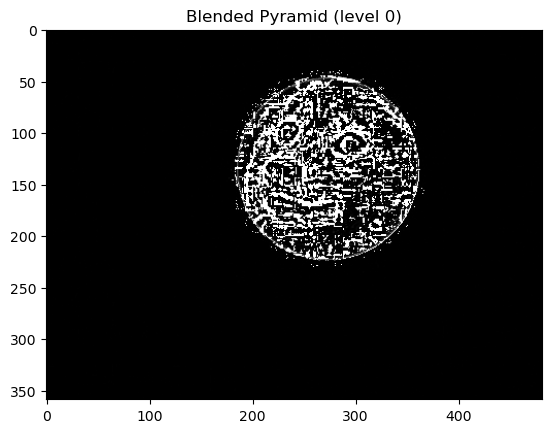

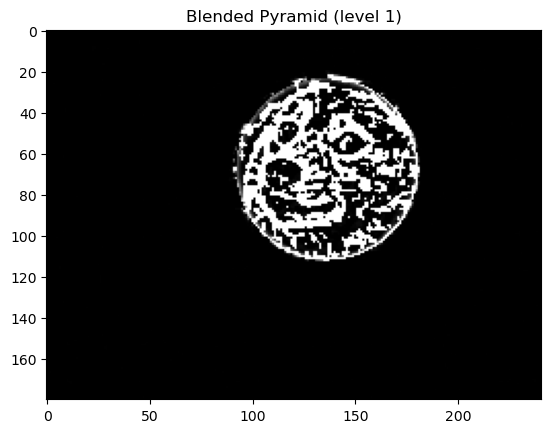

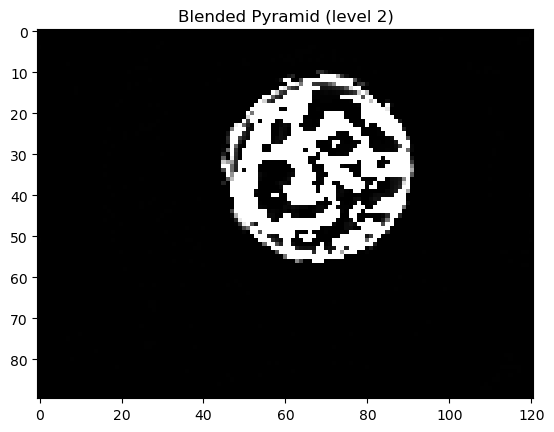

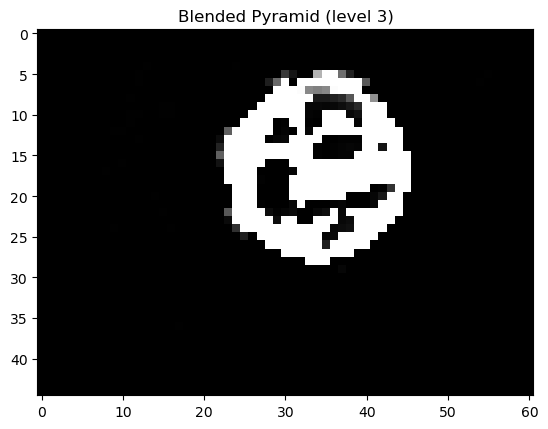

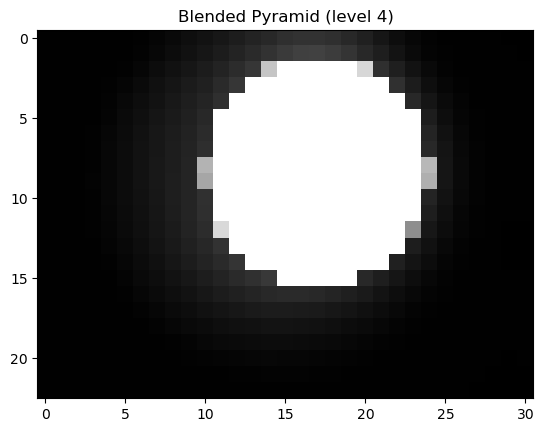

In [14]:
blended_dog_moon_pyramid = blend_pyramids(laplacian_pyramid_dog, laplacian_pyramid_moon, gaussian_pyramid_mask)

print("Laplasian Pyramid of blended Dog/Moon")
for i, el in enumerate(blended_dog_moon_pyramid):
    display_image(f'Blended Pyramid (level {i})', el)


* Collapse the LS pyramid to obtain the final composite image:
$LS_l = LS_l + expand(LS_{l+1})$. Apply the blending operation on the images
inside task4 (the results will be funny).

In [15]:
def collapse_laplacian_pyramide(blended_pyramid):
    """
    Collapses laplacian pyramid to one image.
    """
    collapsed = blended_pyramid[-1].astype(float)
    for i in range(len(blended_pyramid) - 2, -1, -1):
        # collapsed = expand_my(collapsed, blended_pyramid[i].shape)
        collapsed = cv.resize(collapsed, (blended_pyramid[i].shape[1], blended_pyramid[i].shape[0]))
        collapsed = collapsed + blended_pyramid[i]
    return ((collapsed / collapsed.max()) * 255).astype(np.uint8)

Blended Dog/Moon collapsed Image


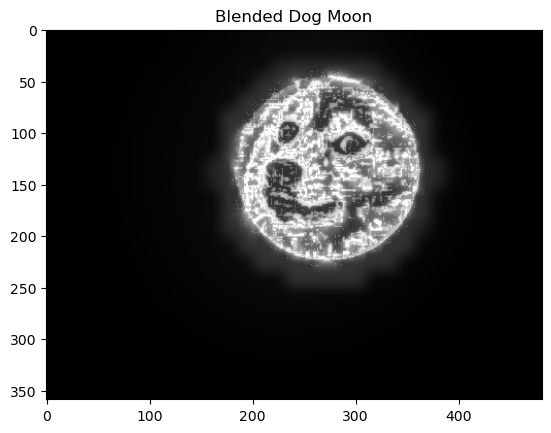

In [16]:
blended_dog_moon = collapse_laplacian_pyramide(blended_dog_moon_pyramid)
print("Blended Dog/Moon collapsed Image")
display_image('Blended Dog Moon', blended_dog_moon)